In [1]:
%load_ext autoreload
%autoreload 2

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
from stable_baselines3 import PPO, A2C
from IPython.display import clear_output

import glob

In [179]:
import sys
sys.path.append(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code")
from RL_trading_envs import StockWithVolHold


In [180]:
def pnl_metric(y, yhat):
    return sum(y * yhat)

In [181]:
df = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\df_test_mestrado.pkl")

df.loc[:, 'volatility'] = df.groupby('asset_identifier')['t_minus_1'].apply(lambda x: x.rolling(35).std())

df                           = df[['asset_identifier', 'date', 'volatility', 'yhat', 'target']]
df                           = df.rename(columns = {'target': 'target_return'})
df.loc[:, 'realized_return'] = df.groupby("asset_identifier")['target_return'].shift(1)

df                           = df.dropna()
df.loc[:, 'date'] = df['date'].factorize()[0]
df.loc[:, 'asset_identifier'] = df['asset_identifier'].factorize()[0]

df.sort_values('date', inplace = True)
df.reset_index(drop = True, inplace = True)

In [182]:
# df.query("asset_identifier < 10", inplace = True)

In [183]:
df_test  = df.query("date > 1400").reset_index(drop = True)
df_test.loc[:, 'date'] = df_test['date'].factorize()[0]

In [184]:
df_valid = df.query("date < 1400").reset_index(drop = True)
df_valid.loc[:, 'date'] = df_valid['date'].factorize()[0]

In [185]:
# assets = [0, 125, 169, 43, 46, 138, 140, 174, 50]
assets = [169]
df_valid.query("asset_identifier.isin(@assets) & date < 100", inplace = True)
# df_valid.loc[:, 'target_return'] = df_valid.loc[:, 'target_return'] - df_valid.loc[:, 'target_return'].mean()
df_valid.reset_index(drop = True, inplace = True)

In [186]:
df_valid[['yhat', 'target_return']].corr()

,yhat,target_return
yhat,1.000000,0.083807
target_return,0.083807,1.000000


In [187]:
df_test[['yhat', 'target_return']].corr()

,yhat,target_return
yhat,1.000000,0.028055
target_return,0.028055,1.000000


In [188]:
# df_valid.loc[:, 'yhat'] = df_valid['target_return']
# df_valid['yhat'] = df_valid['yhat'] * 0.000467/ df_valid['yhat'].std()

In [189]:
df_valid.std(numeric_only = True)

asset_identifier     0.000000
date                29.011492
volatility           0.001193
yhat                 0.000381
target_return        0.015436
realized_return      0.015410
dtype: float64

In [190]:
def get_actions_notionals(df_valid, model):
    env = StockWithVolHold(df_valid)
    done = False
    obs = env.reset()
    list_hidden_state = []
    list_actions = []
    day = 0
    while not done:#not done:
        action, _ = model.predict(obs, deterministic = True)
        obs, reward, done, hidden_state = env.step(action)
        if hidden_state:
            features = env.state_to_features(True)
            hidden_state = pd.DataFrame(hidden_state).T.reset_index()
            hidden_state.columns = ['asset_identifier', 'notional', 'vol']
            hidden_state.loc[:, 'date'] = day
            hidden_state.loc[:, 'available_notional'] = features['available_notional']
            day += 1
            list_hidden_state.append(hidden_state)
        list_actions.append(action.item())
    hidden_state = pd.concat(list_hidden_state)
    return list_actions, hidden_state, env

In [191]:
def get_log_name(logdir):
    folders = glob.glob(logdir + '/*')
    ppo_names = [folder.split('\\')[-1] for folder in folders]
    ppo_index = [int(name.split('_')[-2]) for name in ppo_names if 'PPO' in name]
    ppo_index = max(ppo_index) + 1
    tb_log_name = 'PPO_' + str(ppo_index)
    return tb_log_name


In [192]:
# agent_parameters = dict(learning_rate=0.0003,
#                         n_steps=2048,
#                         batch_size=64,
#                         n_epochs=10)
agent_parameters = dict(n_steps=100)
# agent_parameters = {}
def fit_rl_ppo(df_valid, agent_parameters):
    logdir = r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code\notebooks\log_dir"
    env   = StockWithVolHold(df_valid)
    model = PPO('MlpPolicy', env, verbose=0, tensorboard_log = logdir, **agent_parameters)
    list_results = []
    tb_log_name = get_log_name(logdir)
    for i in range(10):
        clear_output(wait=True)
        model.learn(total_timesteps=len(df_valid),
                    reset_num_timesteps = False,
                    tb_log_name = tb_log_name)
        model.save(f'models_save/model_{tb_log_name}')
        print(i)
    return model

def fit_rl_a2c(df_valid, agent_parameters):
    logdir = r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code\notebooks\log_dir"
    env   = StockWithVolHold(df_valid)
    model = A2C('MlpPolicy', env, verbose=0, tensorboard_log = logdir, **agent_parameters)
    list_results = []
    for i in range(48):
        clear_output(wait=True)
        model.learn(total_timesteps=len(df_valid), reset_num_timesteps = False, tb_log_name = 'A2C')
        model.save(f'models_save/model_a2c_{i}')
        print(i)
    return model

In [193]:
%matplotlib inline

In [194]:
%%time
model = fit_rl_ppo(df_valid, agent_parameters)

NEW DAY: 1
NEW DAY: 2
NEW DAY: 3
NEW DAY: 4
NEW DAY: 5
NEW DAY: 6
NEW DAY: 7
NEW DAY: 8
NEW DAY: 9
NEW DAY: 10
NEW DAY: 11
NEW DAY: 12
NEW DAY: 13
NEW DAY: 14
NEW DAY: 15
NEW DAY: 16
NEW DAY: 17
NEW DAY: 18
NEW DAY: 19
NEW DAY: 20
NEW DAY: 21
NEW DAY: 22
NEW DAY: 23
NEW DAY: 24
NEW DAY: 25
NEW DAY: 26
NEW DAY: 27
NEW DAY: 28
NEW DAY: 29
NEW DAY: 30
NEW DAY: 31
NEW DAY: 32
NEW DAY: 33
NEW DAY: 34
NEW DAY: 35
NEW DAY: 36
NEW DAY: 37
NEW DAY: 38
NEW DAY: 39
NEW DAY: 40
NEW DAY: 41
NEW DAY: 42
NEW DAY: 43
NEW DAY: 44
NEW DAY: 45
NEW DAY: 46
NEW DAY: 47
NEW DAY: 48
NEW DAY: 49
NEW DAY: 50
NEW DAY: 51
NEW DAY: 52
NEW DAY: 53
NEW DAY: 54
NEW DAY: 55
NEW DAY: 56
NEW DAY: 57
NEW DAY: 58
NEW DAY: 59
NEW DAY: 60
NEW DAY: 61
NEW DAY: 62
NEW DAY: 63
NEW DAY: 64
NEW DAY: 65
NEW DAY: 66
NEW DAY: 67
NEW DAY: 68
NEW DAY: 69
NEW DAY: 70
NEW DAY: 71
NEW DAY: 72
NEW DAY: 73
NEW DAY: 74
NEW DAY: 75
NEW DAY: 76
NEW DAY: 77
NEW DAY: 78
NEW DAY: 79
NEW DAY: 80
NEW DAY: 81
NEW DAY: 82
NEW DAY: 83
NEW DAY: 84
N

In [195]:
# %%time
# model = fit_rl_a2c(df_valid, agent_parameters)

In [196]:
# df_valid = df_test

In [197]:
# env = StockWithVolHold(df_valid)
# model = PPO.load('models_save/model_ppo_200', env)

In [198]:
def evaluate_df_model(df_valid, model):
    #Run simulation on df_valid
    list_actions, hidden_state, env = get_actions_notionals(df_valid, model)
    clear_output(wait = True)
    sum_rewards = np.sum(env.rewards_memory)
    #Check correlation between actions and alocations with yhat
    df_valid.loc[:, 'action'] = list_actions
    df_merge = df_valid.merge(hidden_state, on = ['asset_identifier', 'date'])
    action_corr = df_merge[['action', 'yhat']].corr().iloc[0, 1]
    notional_corr = df_merge[['notional', 'yhat']].corr().iloc[0, 1]
    print("-- ** -- ** -- **")
    print("action correlation with yhat:   " + str(action_corr))
    print("notional correlation with yhat: " + str(notional_corr))
    print("-- ** -- ** -- **")
    #Plot action distribution
    plt.figure()
    plt.hist(list_actions)
    plt.xlabel("action")
    plt.title("action distribution")
    #Plot pnl performance
    plt.figure()
    df_merge.loc[:, 'average_notional'] = df_merge['notional'].abs().mean()
    df_merge.eval("pnl = notional * target_return", inplace = True)
    df_merge.eval("pnl_average = average_notional * target_return", inplace = True)
    df_merge.groupby('date')['pnl'].sum().cumsum().plot(label = 'agent_performance')
    df_merge.groupby('date')['pnl_average'].sum().cumsum().plot()
    plt.legend()
    plt.grid()
    #Plot notional
    plt.figure()
    df_merge.groupby('date')['notional'].apply(lambda x: x.abs().sum()).plot(label = 'notional gross')
    df_merge.groupby('date')['notional'].apply(lambda x: x.sum()).plot(label = 'notional net')
    plt.legend()
    plt.grid()
    #Plot volatility
    df_merge.eval("variance = (notional * vol)**2", inplace = True)
    port_var = df_merge.groupby('date')['variance'].sum()
    port_vol = port_var**0.5
    df_merge.eval("average_variance = (average_notional * vol)**2", inplace = True)
    average_var = df_merge.groupby('date')['average_variance'].sum()
    average_vol = average_var**0.5
    plt.figure()
    plt.plot(port_vol, label = 'portfolio volatility')
    plt.plot(average_vol, label = 'equal weight volatility')
    plt.legend()
    plt.grid()
    return df_merge

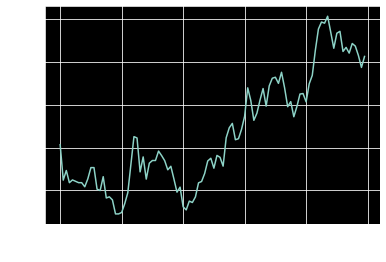

In [199]:
%matplotlib inline
df_valid.groupby('date')['target_return'].sum().cumsum().plot()
plt.grid()

In [176]:
df_valid['target_return'].sum()

0.10665363

-- ** -- ** -- **
action correlation with yhat:   0.6439893910098491
notional correlation with yhat: -0.41731960215224617
-- ** -- ** -- **
Wall time: 2.58 s


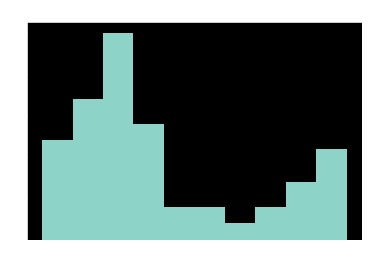

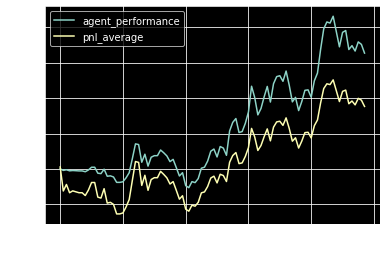

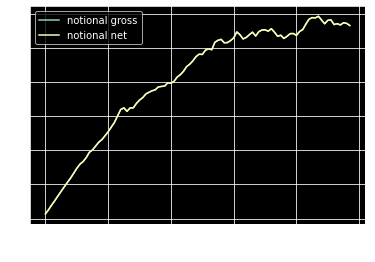

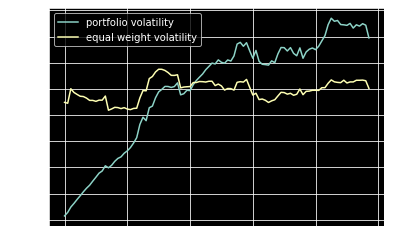

In [177]:
%%time
df_results = evaluate_df_model(df_valid, model)

In [104]:
%%time
evaluate_df_model(df_test, model)

NEW DAY: 1
NEW DAY: 2
NEW DAY: 3
NEW DAY: 4
NEW DAY: 5


KeyboardInterrupt: 

In [31]:
def sweep_feature(model, env, features_base_values, sweep_dict):
    feature_to_sweep = list(sweep_dict.keys())[0]
    values_to_sweep = sweep_dict[feature_to_sweep]
    list_action = []
    for value in values_to_sweep:
        features = features_base_values.copy()
        features[feature_to_sweep] = value
        obs = env.features_to_state(**features)
        action, _ = model.predict(obs, deterministic = True)
        list_action.append(action.item())
    #Plot action vs feature swept
    plt.figure(figsize = (8, 3))
    plt.plot(values_to_sweep, list_action)
    plt.xlabel(feature_to_sweep)
    plt.ylabel("action")
    plt.grid()

<AxesSubplot:>

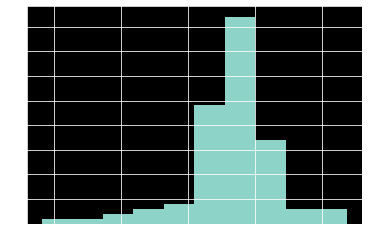

In [34]:
df_valid['yhat'].hist()

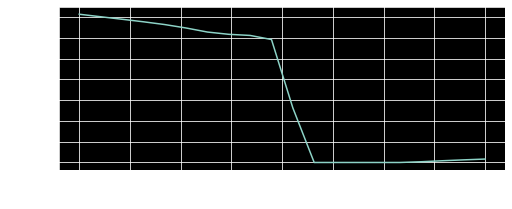

In [94]:
env = StockWithVolHold(df_valid)
features_base_values = {'portfolio_volatility': 0.0009162610978275228,
                         'stock_volatility': 0.012409072890145388,
                         'stock_prediction': 0.00149919418618083,
                         'available_notional': 0.1459195919334888,
                         'stock_notional': 0.8}
sweep_dict = {'stock_prediction': np.linspace(-0.01, 0.01, 20)}
sweep_feature(model, env, features_base_values, sweep_dict)

In [73]:
df_valid.loc[:, 'yhat'] = df_valid.loc[:, 'target_return'] * df_valid.loc[:, 'yhat'].std() / df_valid.loc[:, 'target_return']

In [91]:
env = StockWithVolHold(df_valid)
done = False
obs = env.reset()
list_hidden_state = []
list_actions = []
day = 0


In [93]:
env.state

array([  1.38917911,   1.37177969,   3.35946504,  -0.01268383,
       -10.12683828])

In [92]:
while not done:#not done:
    action, _ = model.predict(obs, deterministic = True)
    obs, reward, done, hidden_state = env.step(action)
    if hidden_state:
        features = env.state_to_features(True)
        hidden_state = pd.DataFrame(hidden_state).T.reset_index()
        hidden_state.columns = ['asset_identifier', 'notional', 'vol']
        hidden_state.loc[:, 'date'] = day
        hidden_state.loc[:, 'available_notional'] = features['available_notional']
        day += 1
        list_hidden_state.append(hidden_state)
    list_actions.append(action.item())
    if np.random.uniform() > 0.95:
        break

NEW DAY: 1
NEW DAY: 2
NEW DAY: 3
NEW DAY: 4
NEW DAY: 5
NEW DAY: 6
NEW DAY: 7
NEW DAY: 8
NEW DAY: 9
NEW DAY: 10
NEW DAY: 11
NEW DAY: 12
NEW DAY: 13
NEW DAY: 14
NEW DAY: 15
NEW DAY: 16
NEW DAY: 17
NEW DAY: 18
NEW DAY: 19
NEW DAY: 20
NEW DAY: 21
NEW DAY: 22
NEW DAY: 23
NEW DAY: 24
NEW DAY: 25
NEW DAY: 26
NEW DAY: 27
NEW DAY: 28
NEW DAY: 29
NEW DAY: 30
NEW DAY: 31
NEW DAY: 32
NEW DAY: 33
NEW DAY: 34
NEW DAY: 35


In [61]:
list_hidden_state

[   asset_identifier  notional       vol  date  available_notional
 0               169  0.100092  0.012518   0.0            0.899908,
    asset_identifier  notional       vol  date  available_notional
 0               169  0.204735  0.012516   1.0            0.795265,
    asset_identifier  notional       vol  date  available_notional
 0               169    0.3101  0.013098   2.0              0.6899,
    asset_identifier  notional      vol  date  available_notional
 0               169  0.402885  0.01339   3.0            0.597115,
    asset_identifier  notional       vol  date  available_notional
 0               169  0.499132  0.013245   4.0            0.500868,
    asset_identifier  notional      vol  date  available_notional
 0               169  0.605979  0.01332   5.0            0.394021,
    asset_identifier  notional       vol  date  available_notional
 0               169  0.715845  0.013428   6.0            0.284155,
    asset_identifier  notional       vol  date  available_n

In [72]:
np.array(env.rewards_memory)[1]/300

0.004535091687577896

In [69]:
df_results#['pnl'].sum()

,asset_identifier,date,volatility,yhat,target_return,realized_return,action,notional,vol,available_notional,average_notional,pnl,pnl_average,variance,average_variance
0,169,0,0.012409,0.001499,0.000376,-0.010584,1.000000,0.100092,0.012518,0.899908,0.979008,0.000038,0.000368,0.000002,0.000150
1,169,1,0.012518,0.001500,0.022665,0.000917,1.000000,0.204735,0.012516,0.795265,0.979008,0.004640,0.022189,0.000007,0.000150
2,169,2,0.012516,0.001443,0.017066,0.023206,1.000000,0.310100,0.013098,0.689900,0.979008,0.005292,0.016707,0.000016,0.000164
3,169,3,0.013098,0.001062,-0.018136,0.017607,1.000000,0.402885,0.013390,0.597115,0.979008,-0.007307,-0.017756,0.000029,0.000172
4,169,4,0.013390,0.000807,-0.008004,-0.017595,1.000000,0.499132,0.013245,0.500868,0.979008,-0.003995,-0.007836,0.000044,0.000168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,169,93,0.016396,0.001243,0.010522,0.001231,1.000000,1.097418,0.015479,-0.097418,0.979008,0.011547,0.010301,0.000289,0.000230
94,169,94,0.015479,0.001277,0.014657,0.011063,1.000000,1.114096,0.014573,-0.114096,0.979008,0.016329,0.014349,0.000264,0.000204
95,169,95,0.014573,0.001237,0.032692,0.015198,1.000000,1.151121,0.014786,-0.151121,0.979008,0.037633,0.032006,0.000290,0.000210
96,169,96,0.014786,0.001053,-0.015319,0.033233,1.000000,1.134109,0.014042,-0.134109,0.979008,-0.017374,-0.014998,0.000254,0.000189


In [65]:
df_valid

,asset_identifier,date,volatility,yhat,target_return,realized_return,action
0,169,0,0.012409,0.001499,0.000376,-0.010584,1.000000
1,169,1,0.012518,0.001500,0.022665,0.000917,1.000000
2,169,2,0.012516,0.001443,0.017066,0.023206,1.000000
3,169,3,0.013098,0.001062,-0.018136,0.017607,1.000000
4,169,4,0.013390,0.000807,-0.008004,-0.017595,1.000000
...,...,...,...,...,...,...,...
95,169,95,0.014573,0.001237,0.032692,0.015198,1.000000
96,169,96,0.014786,0.001053,-0.015319,0.033233,1.000000
97,169,97,0.014042,0.000361,-0.023776,-0.014778,0.554681
98,169,98,0.014109,0.000830,0.007890,-0.023235,1.000000


In [63]:
len(env.rewards_memory)

99

In [44]:
action

array([0.5515774], dtype=float32)

In [46]:
reward

0.07794904377806944

In [48]:
0.05515 * 0.004711 * 30

0.0077943495

In [45]:
df_results

,asset_identifier,date,volatility,yhat,target_return,realized_return,action,notional,vol,available_notional,average_notional,pnl,pnl_average,variance,average_variance
0,174,0,0.016943,0.001477,0.004711,-0.015242,0.551577,0.055158,0.016943,0.662693,0.129749,0.000260,0.000611,8.733162e-07,0.000005
1,169,0,0.012409,0.001499,0.000917,-0.010584,0.555019,0.055502,0.012409,0.662693,0.129749,0.000051,0.000119,4.743456e-07,0.000003
2,138,0,0.012833,0.001394,0.010950,-0.013163,0.540723,0.054072,0.012833,0.662693,0.129749,0.000592,0.001421,4.814812e-07,0.000003
3,125,0,0.015086,0.001692,-0.005073,-0.014355,0.573805,0.057381,0.015086,0.662693,0.129749,-0.000291,-0.000658,7.493260e-07,0.000004
4,50,0,0.013534,0.001556,0.009019,0.003961,0.560789,0.056079,0.013534,0.662693,0.129749,0.000506,0.001170,5.760537e-07,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,46,98,0.015907,0.000453,-0.013014,0.001715,0.109608,0.000000,0.016063,0.000000,0.129749,-0.000000,-0.001689,0.000000e+00,0.000004
754,174,98,0.017957,0.001148,0.008097,-0.021395,0.301400,0.199739,0.017957,0.000000,0.129749,0.001617,0.001051,1.286519e-05,0.000005
755,169,98,0.014109,0.000830,0.008431,-0.023235,0.036144,0.330228,0.014109,0.000000,0.129749,0.002784,0.001094,2.170781e-05,0.000003
756,50,98,0.021371,0.001276,-0.010926,0.018150,0.468095,0.053057,0.021371,0.000000,0.129749,-0.000580,-0.001418,1.285703e-06,0.000008


In [50]:
action, _ = model.predict(obs, deterministic = True)
obs, reward, done, hidden_state = env.step(action)

In [46]:
env.state_to_features(True)

{'portfolio_volatility': 0.0009162610978275228,
 'stock_volatility': 0.012409072890145388,
 'stock_prediction': 0.00149919418618083,
 'available_notional': 0.9459195919334888,
 'stock_notional': 0.0}

In [51]:
action

array([0.41854703], dtype=float32)

In [56]:
df_results['pnl'].sum()*30

5.265160101418453

In [ ]:
hidden_state = pd.concat(list_hidden_state)
return list_actions, hidden_state, env